# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
!pip install pandas-datareader

In [3]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Función para obtener los datos ajustados al cierre desde Yahoo
def getClose(names, start, end):
    return web.DataReader(names,'yahoo',start,end)['Adj Close']

In [6]:
names=['AAPL','GOOG'] # Apple, Google
start='2016-01-01'
end='2022-06-21'
data=getClose(names,start,end)
data.head() # Mostarmos los primeros cinco

Symbols,AAPL,GOOG
Date,,
2016-01-04,24.185045,741.840027
2016-01-05,23.578983,742.580017
2016-01-06,23.117552,743.619995
2016-01-07,22.141884,726.390015
2016-01-08,22.258965,714.469971


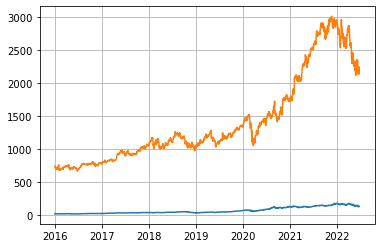

In [10]:
plt.plot(data)
plt.grid()

<AxesSubplot:xlabel='Date'>

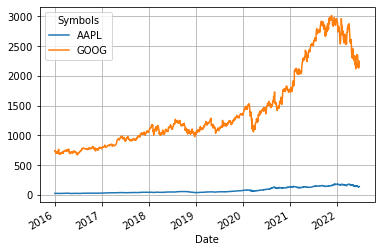

In [7]:
data.plot(grid=True)

In [11]:
# Acceder a Apple
data['AAPL'] # Regresa todas las fechas

Date
2016-01-04     24.185045
2016-01-05     23.578983
2016-01-06     23.117552
2016-01-07     22.141884
2016-01-08     22.258965
                 ...    
2022-06-14    132.759995
2022-06-15    135.429993
2022-06-16    130.059998
2022-06-17    131.559998
2022-06-21    136.619995
Name: AAPL, Length: 1628, dtype: float64

In [15]:
# Acceder al 4 de enero de 2016
data.loc['2016-01-04'] # La fecha es explícita

Symbols
AAPL     24.185045
GOOG    741.840027
Name: 2016-01-04 00:00:00, dtype: float64

In [16]:
# Acceder al primer elemento
data.iloc[0] # La fecha es una posición

Symbols
AAPL     24.185045
GOOG    741.840027
Name: 2016-01-04 00:00:00, dtype: float64

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

In [17]:
R=((data-data.shift())/data.shift()).dropna() # dropna -> elimina los NaN
R.head()

Symbols,AAPL,GOOG
Date,,
2016-01-05,-0.025059,0.000998
2016-01-06,-0.019570,0.001400
2016-01-07,-0.042205,-0.023170
2016-01-08,0.005288,-0.016410
2016-01-11,0.016192,0.002184


In [19]:
r=np.log(data/data.shift()).dropna()
r.head()

Symbols,AAPL,GOOG
Date,,
2016-01-05,-0.025379,0.000997
2016-01-06,-0.019764,0.001400
2016-01-07,-0.043121,-0.023443
2016-01-08,0.005274,-0.016546
2016-01-11,0.016063,0.002181


<AxesSubplot:xlabel='Date'>

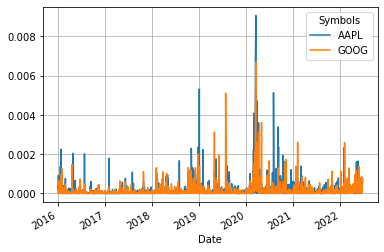

In [20]:
(R-r).plot(grid=True)

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GOOG'}>]], dtype=object)

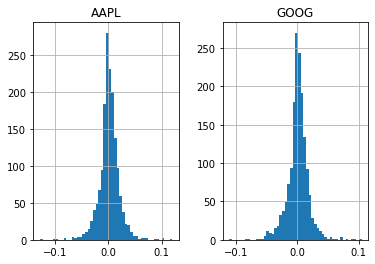

In [21]:
R.hist(bins=50)

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GOOG'}>]], dtype=object)

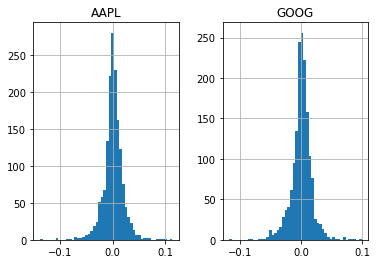

In [22]:
r.hist(bins=50)

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [23]:
R.mean()

Symbols
AAPL    0.001243
GOOG    0.000825
dtype: float64

In [24]:
r.mean()

Symbols
AAPL    0.001064
GOOG    0.000681
dtype: float64

In [25]:
R.std()

Symbols
AAPL    0.018868
GOOG    0.016993
dtype: float64

In [26]:
r.std()

Symbols
AAPL    0.018887
GOOG    0.017008
dtype: float64

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [27]:
dias=10
N=1000
AAPL_R=np.random.normal(R['AAPL'].mean(), # Media de Apple
                        R['AAPL'].std(),  # Desviación estandar de Apple
                        (dias,N)          # Dimensión de la matriz aleatoria
                       )
GOOG_R=np.random.normal(R['GOOG'].mean(), # Media de Google
                        R['GOOG'].std(),  # Desviación estandar de Google
                        (dias,N)          # Dimensión de la matriz aleatoria
                       )

In [31]:
R.mean()

Symbols
AAPL    0.001243
GOOG    0.000825
dtype: float64

In [29]:
AAPL_R.mean(axis=0) # Calculamos la media por renglones

array([-1.80408888e-03,  5.69850082e-03,  9.61997463e-03,  3.26477214e-03,
        1.17336824e-02, -7.34832804e-04,  6.45010784e-03,  6.27679839e-03,
       -1.44943149e-03,  8.17051476e-03, -5.89022024e-03,  1.01034400e-03,
       -2.75848448e-03, -2.64032353e-03, -8.90484247e-04, -6.01556982e-03,
        2.80727585e-03,  8.93647363e-03,  4.32235433e-03,  1.28163418e-02,
        7.19885421e-03,  3.00788429e-03, -1.55364300e-03,  1.66988001e-02,
       -1.23685296e-03,  2.23274155e-03,  8.16173186e-04,  8.78502998e-03,
        4.51380663e-03, -1.30038154e-04,  1.70699332e-02, -2.85464783e-04,
        5.52005777e-03,  8.30302391e-03,  4.75952932e-04, -7.37946956e-03,
       -1.30077129e-03,  4.02952779e-03,  3.47952445e-03,  2.70968588e-03,
        1.93511958e-03, -7.68977778e-03,  9.59322310e-03,  2.78537233e-03,
        1.57870245e-03,  6.75592309e-03, -4.26209385e-03,  8.44639229e-03,
       -3.44415907e-03, -1.09157923e-06,  6.13895381e-03,  1.66522768e-03,
        6.59196896e-03, -

In [32]:
AAPL_R.mean(axis=0).mean() # Calculamos la media de los 'N' escenarios

0.001277186509323833

In [33]:
AAPL_R.mean()

0.0012771865093238327

In [34]:
GOOG_R.mean()

0.0007374854736053247

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2018, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2019 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [35]:
pd.date_range?

In [38]:
def sim(me,std,inicio,dias,N):
    fechas=pd.date_range(inicio,periods=dias)
    R=np.random.normal(me,std,(dias,N))
    return pd.DataFrame(data=R,index=fechas)

In [56]:
AAPL_R=sim(R['AAPL'].mean(),
          R['AAPL'].std(),
          '2022-06-22',
           365,
           1000)
GOOG_R=sim(R['GOOG'].mean(),
           R['GOOG'].std(),
           '2022-06-22',
           365,
            1000)

In [41]:
data.iloc[-1]

Symbols
AAPL     136.619995
GOOG    2244.889893
Name: 2022-06-21 00:00:00, dtype: float64

In [44]:
AAPL_R.iloc[0]

0     -0.023336
1      0.006148
2     -0.028374
3     -0.016637
4     -0.017706
         ...   
995    0.000511
996    0.011547
997    0.023990
998    0.004117
999    0.040036
Name: 2022-06-22 00:00:00, Length: 1000, dtype: float64

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [57]:
AAPL=data['AAPL'].iloc[-1]*(AAPL_R+1).cumprod() # cumprod -> producto acumulado
GOOG=data['GOOG'].iloc[-1]*(GOOG_R+1).cumprod()

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [58]:
# Vemos cuántos escenarios superan el 20% del precio de hoy
Umbral=data.iloc[-1]*1.2
Umbral

Symbols
AAPL     163.943994
GOOG    2693.867871
Name: 2022-06-21 00:00:00, dtype: float64

<AxesSubplot:>

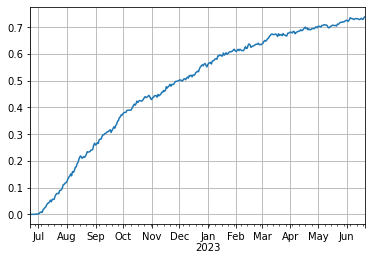

In [54]:
B_AAPL=AAPL>Umbral['AAPL'] # Variable de Bernoulli
P_AAPL=B_AAPL.mean(axis=1) # Probabilidad de que se supere el Umbral
P_AAPL.plot(grid=True)

<AxesSubplot:>

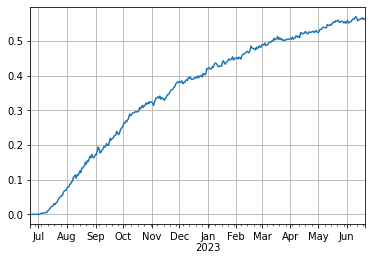

In [59]:
B_GOOG=GOOG>Umbral['GOOG']
P_GOOG=B_GOOG.mean(axis=1)
P_GOOG.plot(grid=True)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.